In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 84473492.52it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print("First data point")
print(f"Shape: {trainset[0][0].size()}")
print(f"Tensor: {trainset[0][0]}")
print(f"Label: {trainset[0][1]}")

First data point
Shape: torch.Size([3, 32, 32])
Tensor: tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000,

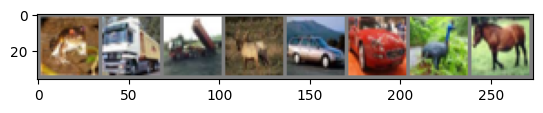

frog  truck truck deer  car   car   bird  horse


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_dataloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [3]:
train_dataloader = DataLoader(trainset, batch_size)
test_dataloader = DataLoader(testset, batch_size)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class NNmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu = nn.Sequential(
        nn.Linear(3*32*32, 500),
        nn.ReLU(),
        nn.Linear(500, 500),
        nn.ReLU(),
        nn.Linear(500, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    return self.linear_relu(x)


In [ ]:
model = NNmodel().to(device)
print(model)

NNmodel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu): Sequential(
    (0): Linear(in_features=3072, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [47]:
def train_loop(dataloader, model, loss_fn, optimizer):
  total_loss, correct = 0, 0
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.cuda(), y.cuda()
    pred = model(X)
    loss = loss_fn(pred, y)
    total_loss += loss.item()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if batch%500 == 499:
      print(f"loss: {loss:.7f}  [{batch+1:5d}/{len(dataloader):5d}]")
  accuracy = correct/float(len(dataloader.dataset))
  print("---Train---")
  print(f"Correct predictions: {correct}")
  print(f"Accuracy: {accuracy}")
  return total_loss, accuracy

def test_loop(dataloader, model, loss_fun):
  total_loss, correct = 0, 0
  model.eval()
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.cuda(), y.cuda()
      pred = model(X)
      loss = loss_fn(pred, y)
      total_loss += loss.item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    accuracy = correct/float(len(dataloader.dataset))
    print("---Test---")
    print(f"Correct predictions: {correct}")
    print(f"Accuracy: {accuracy}")
    print(f"Total loss: {total_loss}")
  return total_loss, accuracy



In [ ]:
learning_rate = 1e-5
epochs = 10

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loss_output, test_acc_output = test_loop(test_dataloader, model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  test_loss.append(test_loss_output)
  test_accuracy.append(test_acc_output)

Epoch 1
loss: 1.2947226  [  500/ 6250]
loss: 1.7623422  [ 1000/ 6250]
loss: 1.5932159  [ 1500/ 6250]
loss: 1.7749579  [ 2000/ 6250]
loss: 0.9141514  [ 2500/ 6250]
loss: 1.6138884  [ 3000/ 6250]
loss: 1.6827869  [ 3500/ 6250]
loss: 0.9281802  [ 4000/ 6250]
loss: 1.4557153  [ 4500/ 6250]
loss: 1.5602539  [ 5000/ 6250]
loss: 0.5904552  [ 5500/ 6250]
loss: 1.4430602  [ 6000/ 6250]
---Train---
Correct predictions: 27289.0
Accuracy: 0.54578
---Test---
Correct predictions: 5156.0
Accuracy: 0.5156
Total loss: 1737.4005517661572
Epoch 2
loss: 1.2971385  [  500/ 6250]
loss: 1.7618128  [ 1000/ 6250]
loss: 1.5854790  [ 1500/ 6250]
loss: 1.7705899  [ 2000/ 6250]
loss: 0.9140759  [ 2500/ 6250]
loss: 1.6080565  [ 3000/ 6250]
loss: 1.6906492  [ 3500/ 6250]
loss: 0.9189127  [ 4000/ 6250]
loss: 1.4498628  [ 4500/ 6250]
loss: 1.5696900  [ 5000/ 6250]
loss: 0.5892566  [ 5500/ 6250]
loss: 1.4380214  [ 6000/ 6250]
---Train---
Correct predictions: 27331.0
Accuracy: 0.54662
---Test---
Correct predictions: 515

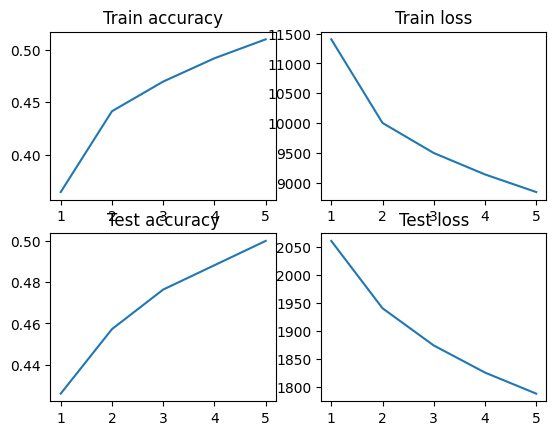

<Figure size 1500x1000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(2, 2)
plt.figure(figsize=(15, 10))
indexes = [i for i in range(1, epochs+1)]
axs[0, 0].plot(indexes, train_accuracy)
axs[0, 0].set_title("Train accuracy")
axs[0, 1].plot(indexes, train_loss)
axs[0, 1].set_title("Train loss")
axs[1, 0].plot(indexes, test_accuracy)
axs[1, 0].set_title("Test accuracy")
axs[1, 1].plot(indexes, test_loss)
axs[1, 1].set_title("Test loss")
fig.show()

#CNN

In [ ]:
class CNNmodel(nn.Module):
  def __init__(self):
      super().__init__()
      self.network = nn.Sequential(
          #3x32x32 -> 12x30x30
          nn.Conv2d(3, 12, 3),
          nn.ReLU(),
          nn.Dropout(0.2),
          #12x30x30 -> 12x15x15
          nn.MaxPool2d(2, 2),
          #12x15x15 -> 24x13x13
          nn.Conv2d(12, 24, 3),
          nn.ReLU(),
          nn.Dropout(0.2),
          #24x13x13 -> 24x6x6
          nn.MaxPool2d(2, 2),
          #Flatten all except batch
          #24x6x6 -> 864
          nn.Flatten(),
          nn.Linear(864, 300),
          nn.ReLU(),
          nn.Linear(300, 10)
          )
  def forward(self, x):
      return self.network(x)


In [ ]:
cnn_model = CNNmodel().to(device)
print(cnn_model)

CNNmodel(
  (network): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=864, out_features=300, bias=True)
    (10): ReLU()
    (11): Linear(in_features=300, out_features=10, bias=True)
  )
)


In [ ]:
from torchsummary import summary
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 30, 30]             336
              ReLU-2           [-1, 12, 30, 30]               0
           Dropout-3           [-1, 12, 30, 30]               0
         MaxPool2d-4           [-1, 12, 15, 15]               0
            Conv2d-5           [-1, 24, 13, 13]           2,616
              ReLU-6           [-1, 24, 13, 13]               0
           Dropout-7           [-1, 24, 13, 13]               0
         MaxPool2d-8             [-1, 24, 6, 6]               0
           Flatten-9                  [-1, 864]               0
           Linear-10                  [-1, 300]         259,500
             ReLU-11                  [-1, 300]               0
           Linear-12                   [-1, 10]           3,010
Total params: 265,462
Trainable params: 265,462
Non-trainable params: 0
-------------------------------

In [ ]:
learning_rate = 1e-3
epochs = 10

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=learning_rate)

In [ ]:
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  test_loss_output, test_acc_output = test_loop(test_dataloader, cnn_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  test_loss.append(test_loss_output)
  test_accuracy.append(test_acc_output)

Epoch 1
loss: 1.6770505  [  500/ 6250]
loss: 1.9036694  [ 1000/ 6250]
loss: 1.7128434  [ 1500/ 6250]
loss: 1.5278029  [ 2000/ 6250]
loss: 0.9435824  [ 2500/ 6250]
loss: 1.9537954  [ 3000/ 6250]
loss: 1.0333018  [ 3500/ 6250]
loss: 0.7357817  [ 4000/ 6250]
loss: 1.4289434  [ 4500/ 6250]
loss: 1.2801827  [ 5000/ 6250]
loss: 0.9636114  [ 5500/ 6250]
loss: 1.0955724  [ 6000/ 6250]
---Train---
Correct predictions: 25505.0
Accuracy: 0.5101
---Test---
Correct predictions: 5963.0
Accuracy: 0.5963
Total loss: 1430.7347782552242
Epoch 2
loss: 1.1655385  [  500/ 6250]
loss: 1.6296617  [ 1000/ 6250]
loss: 0.9949949  [ 1500/ 6250]
loss: 1.0376091  [ 2000/ 6250]
loss: 0.6070246  [ 2500/ 6250]
loss: 1.7846820  [ 3000/ 6250]
loss: 1.1967964  [ 3500/ 6250]
loss: 0.6007464  [ 4000/ 6250]
loss: 1.7237669  [ 4500/ 6250]
loss: 0.6009410  [ 5000/ 6250]
loss: 0.7147166  [ 5500/ 6250]
loss: 0.7702187  [ 6000/ 6250]
---Train---
Correct predictions: 31477.0
Accuracy: 0.62954
---Test---
Correct predictions: 6433

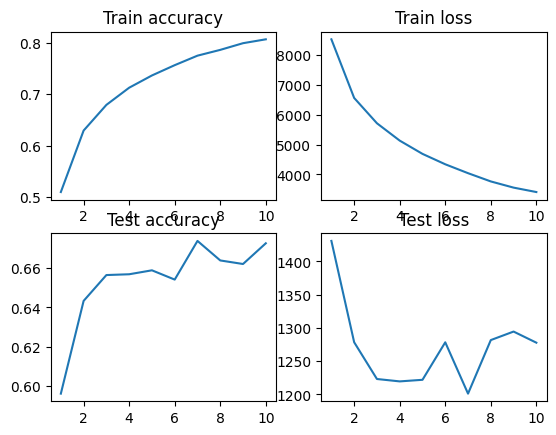

<Figure size 1500x1000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(2, 2)
plt.figure(figsize=(15, 10))
indexes = [i for i in range(1, epochs+1)]
axs[0, 0].plot(indexes, train_accuracy)
axs[0, 0].set_title("Train accuracy")
axs[0, 1].plot(indexes, train_loss)
axs[0, 1].set_title("Train loss")
axs[1, 0].plot(indexes, test_accuracy)
axs[1, 0].set_title("Test accuracy")
axs[1, 1].plot(indexes, test_loss)
axs[1, 1].set_title("Test loss")
fig.show()

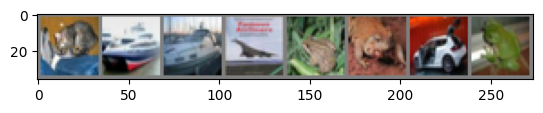

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


In [ ]:
images, labels = next(iter(test_dataloader))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
outputs = cnn_model(images.cuda())
labels = outputs.argmax(1)
print([classes[labels[i]] for i in range(len(labels))])

['cat', 'ship', 'ship', 'plane', 'deer', 'frog', 'horse', 'frog']


## Using pretrained models

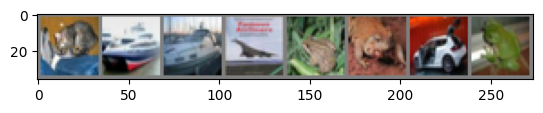

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


In [7]:
images, labels = next(iter(test_dataloader))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

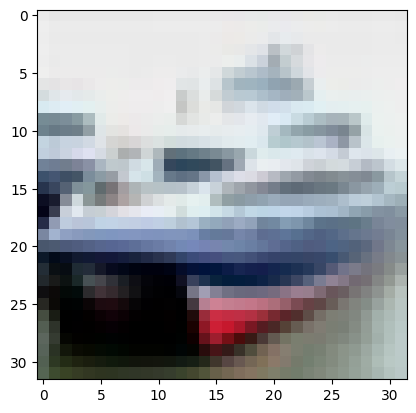

ship


In [24]:
images, labels = next(iter(test_dataloader))

test_image = images[1]
test_label = labels[1]
# print images
imshow(test_image)
print(classes[test_label])

In [34]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
resnet_model = resnet50(weights=weights)
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
preprocess = weights.transforms()

batch = preprocess(test_image).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [36]:
print(batch.size())

torch.Size([1, 3, 224, 224])


In [37]:
prediction = resnet_model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

wall clock: 99.5%


In [38]:
predictions = []
for i in range(len(images)):
  X = images[i]
  batch = preprocess(X).unsqueeze(0)
  prediction = resnet_model(batch).squeeze(0).softmax(0)
  class_id = prediction.argmax().item()
  score = prediction[class_id].item()
  category_name = weights.meta["categories"][class_id]
  predictions.append(f"{category_name}: {100 * score:.1f}%")

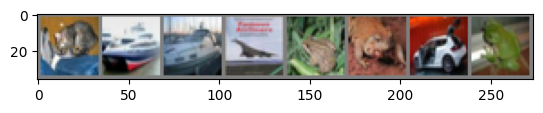

['chocolate sauce: 100.0%', 'wall clock: 99.5%', 'chocolate sauce: 100.0%', 'bubble: 100.0%', 'bow: 99.9%', 'chocolate sauce: 100.0%', 'bolo tie: 100.0%', 'bubble: 100.0%']


In [39]:
imshow(torchvision.utils.make_grid(images))
print(predictions)

## Finetune pretrained model on dataset

In [42]:
#change final layer
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(classes))

In [45]:
from torchsummary import summary
summary(resnet_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [43]:
resnet_model = resnet_model.to(device)

In [44]:
learning_rate = 1e-3
epochs = 10

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=learning_rate)

In [48]:
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, resnet_model, loss_fn, optimizer)
  test_loss_output, test_acc_output = test_loop(test_dataloader, resnet_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  test_loss.append(test_loss_output)
  test_accuracy.append(test_acc_output)

Epoch 1
loss: 1.8752152  [  500/ 6250]
loss: 1.8990338  [ 1000/ 6250]
loss: 2.1716018  [ 1500/ 6250]
loss: 1.8428463  [ 2000/ 6250]
loss: 1.2353336  [ 2500/ 6250]
loss: 1.8948309  [ 3000/ 6250]
loss: 2.1299295  [ 3500/ 6250]
loss: 1.7887170  [ 4000/ 6250]
loss: 1.7928729  [ 4500/ 6250]
loss: 2.3365850  [ 5000/ 6250]
loss: 1.7313513  [ 5500/ 6250]
loss: 1.6709138  [ 6000/ 6250]
---Train---
Correct predictions: 14138.0
Accuracy: 0.28276
---Test---
Correct predictions: 2952.0
Accuracy: 0.2952
Total loss: 9008.271065711975
Epoch 2
loss: 2.1982217  [  500/ 6250]
loss: 1.4477592  [ 1000/ 6250]
loss: 2.4942095  [ 1500/ 6250]
loss: 1.8536105  [ 2000/ 6250]
loss: 1.2222733  [ 2500/ 6250]
loss: 1.8454471  [ 3000/ 6250]
loss: 1.9519665  [ 3500/ 6250]
loss: 1.3820748  [ 4000/ 6250]
loss: 1.6959827  [ 4500/ 6250]
loss: 2.0523427  [ 5000/ 6250]
loss: 1.6251589  [ 5500/ 6250]
loss: 1.8745723  [ 6000/ 6250]
---Train---
Correct predictions: 15832.0
Accuracy: 0.31664
---Test---
Correct predictions: 2866

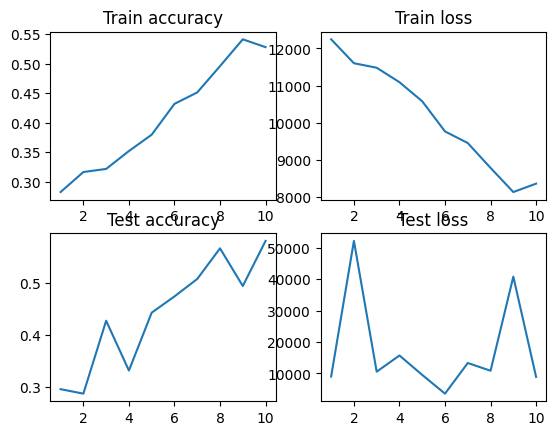

<Figure size 1500x1000 with 0 Axes>

In [49]:
fig, axs = plt.subplots(2, 2)
plt.figure(figsize=(15, 10))
indexes = [i for i in range(1, epochs+1)]
axs[0, 0].plot(indexes, train_accuracy)
axs[0, 0].set_title("Train accuracy")
axs[0, 1].plot(indexes, train_loss)
axs[0, 1].set_title("Train loss")
axs[1, 0].plot(indexes, test_accuracy)
axs[1, 0].set_title("Test accuracy")
axs[1, 1].plot(indexes, test_loss)
axs[1, 1].set_title("Test loss")
fig.show()

In [51]:
#save model
PATH = "resnet_model.pt"
torch.save(resnet_model.state_dict(), PATH)